# Import Librarii

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
import pickle

# Incarcarea datelor

In [49]:
# Monteaza Google Drive
drive.mount('/content/drive')

# Citeste fisierul din MyDrive
df = pd.read_csv('/content/drive/MyDrive/products.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023


# Explorarea datelor

<class 'pandas.core.frame.DataFrame'>
Index: 35267 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35267 non-null  int64  
 1   Product Title    35096 non-null  object 
 2   Merchant ID      35267 non-null  int64  
 3   Category Label   35267 non-null  object 
 4   _Product Code    35172 non-null  object 
 5   Number_of_Views  35253 non-null  float64
 6   Merchant Rating  35097 non-null  float64
 7   Listing Date     35208 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.4+ MB


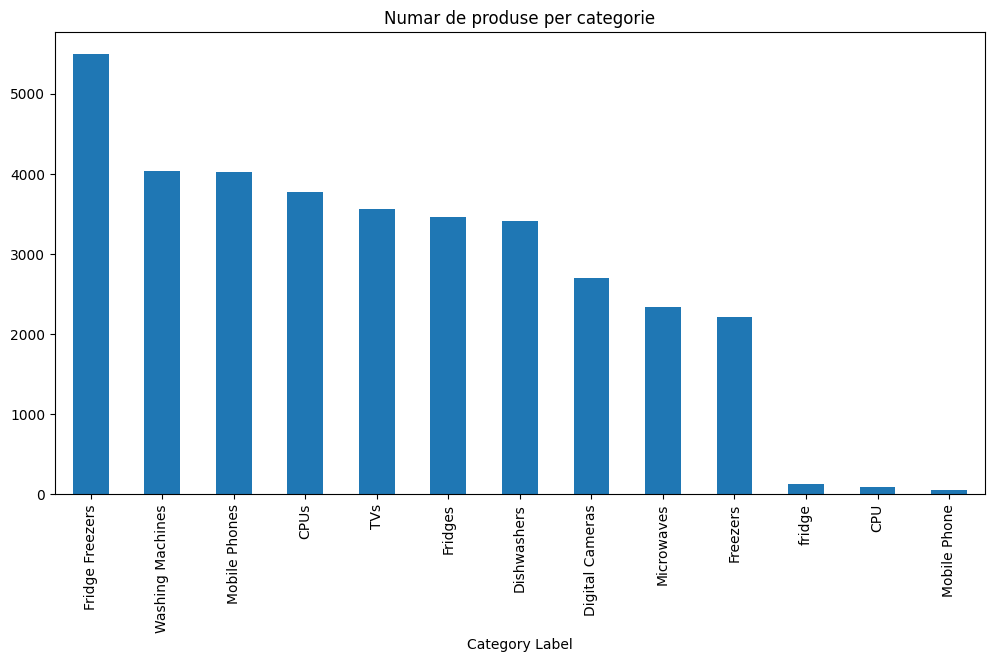

,0
product ID,0
Product Title,171
Merchant ID,0
Category Label,0
_Product Code,95
Number_of_Views,14
Merchant Rating,170
Listing Date,59


In [50]:
# Curatare coloane: sterge spatiile de la inceput si sfarsit
df.columns = df.columns.str.strip()

# Sterge randurile fara categorie
df = df.dropna(subset=['Category Label'])

# Informatii generale
df.info()

# Statistici descriptive
df.describe()

# Numar produse per categorie
df['Category Label'].value_counts().plot(kind='bar', figsize=(12,6))
plt.title("Numar de produse per categorie")
plt.show()

# Verificare valori lipsa
df.isnull().sum()


# Curatarea titlurilor

In [51]:
def clean_title(title):
    title = str(title).lower()                       # lowercase
    title = re.sub(r'[^a-z0-9\s]', '', title)       # elimina caractere speciale
    title = re.sub(r'\s+', ' ', title).strip()      # elimina spatii multiple
    return title

df['clean_title'] = df['Product Title'].apply(clean_title)
df[['Product Title','clean_title']].head()

,Product Title,clean_title
0,apple iphone 8 plus 64gb silver,apple iphone 8 plus 64gb silver
1,apple iphone 8 plus 64 gb spacegrau,apple iphone 8 plus 64 gb spacegrau
2,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,apple mq8n2ba iphone 8 plus 64gb 55 12mp sim f...
3,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey
4,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,apple iphone 8 plus gold 55 64gb 4g unlocked s...


# Feature Engineering simplu

In [52]:
df['title_len'] = df['clean_title'].apply(len)
df['title_word_count'] = df['clean_title'].apply(lambda x: len(x.split()))
df['has_number'] = df['clean_title'].apply(lambda x: int(bool(re.search(r'\d', x))))

df.head()

,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date,clean_title,title_len,title_word_count,has_number
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024,apple iphone 8 plus 64gb silver,31,6,1
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024,apple iphone 8 plus 64 gb spacegrau,35,7,1
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024,apple mq8n2ba iphone 8 plus 64gb 55 12mp sim f...,68,13,1
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022,apple iphone 8 plus 64gb space grey,35,7,1
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023,apple iphone 8 plus gold 55 64gb 4g unlocked s...,53,11,1


# Vectorizarea textului

In [53]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # poti ajusta
X_text = tfidf.fit_transform(df['clean_title'])

# Combinarea cu feature-uri suplimentare
X_features = df[['title_len','title_word_count','has_number']].values
from scipy.sparse import hstack
X = hstack([X_text, X_features])

# Pregatirea setului de antrenare si testare

In [54]:
y = df['Category Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Antrenarea unui model simplu (Logistic Regression)

In [56]:
model = LogisticRegression(max_iter=5000, solver='saga')
model.fit(X_train, y_train)

# Evaluare
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

                  precision    recall  f1-score   support

             CPU       0.00      0.00      0.00        17
            CPUs       0.98      0.98      0.98       754
 Digital Cameras       0.99      0.98      0.99       539
     Dishwashers       0.90      0.94      0.92       684
        Freezers       0.98      0.83      0.90       442
 Fridge Freezers       0.90      0.92      0.91      1099
         Fridges       0.82      0.87      0.85       691
      Microwaves       0.99      0.93      0.96       468
    Mobile Phone       0.00      0.00      0.00        11
   Mobile Phones       0.95      0.99      0.97       804
             TVs       0.96      0.98      0.97       713
Washing Machines       0.94      0.94      0.94       807
          fridge       0.00      0.00      0.00        25

        accuracy                           0.93      7054
       macro avg       0.72      0.72      0.72      7054
    weighted avg       0.93      0.93      0.93      7054



# Salvarea modelului si vectorizatorului

In [ ]:
# Salveaza model
with open('product_classifier.pkl', 'wb') as f:
    pickle.dump(model, f)

# Salveaza TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Testare interactiva direct in notebook

In [ ]:
def predict_category(title):
    clean = clean_title(title)
    x_text = tfidf.transform([clean])
    x_features = np.array([[len(clean), len(clean.split()), int(bool(re.search(r'\d', clean)))]])
    from scipy.sparse import hstack
    x = hstack([x_text, x_features])
    pred = model.predict(x)
    return pred[0]

# Exemplu
predict_category("iphone 7 32gb gold")